# Get coordinates from jpg

## Function to extract lon,lat

In [ ]:
import exifread # on error use pip install exifread

# based on https://gist.github.com/erans/983821

def _get_if_exist(data, key):
    if key in data:
        return data[key]

    return None


def _convert_to_degress(value):
    """
    Helper function to convert the GPS coordinates stored in the EXIF to degress in float format
    :param value:
    :type value: exifread.utils.Ratio
    :rtype: float
    """
    d = float(value.values[0].num) / float(value.values[0].den)
    m = float(value.values[1].num) / float(value.values[1].den)
    s = float(value.values[2].num) / float(value.values[2].den)

    return d + (m / 60.0) + (s / 3600.0)
    
def get_exif_location(exif_data):
    """
    Returns the latitude and longitude, if available, from the provided exif_data (obtained through get_exif_data above)
    """
    lat = None
    lon = None

    gps_latitude = _get_if_exist(exif_data, 'GPS GPSLatitude')
    gps_latitude_ref = _get_if_exist(exif_data, 'GPS GPSLatitudeRef')
    gps_longitude = _get_if_exist(exif_data, 'GPS GPSLongitude')
    gps_longitude_ref = _get_if_exist(exif_data, 'GPS GPSLongitudeRef')

    if gps_latitude and gps_latitude_ref and gps_longitude and gps_longitude_ref:
        lat = _convert_to_degress(gps_latitude)
        if gps_latitude_ref.values[0] != 'N':
            lat = 0 - lat

        lon = _convert_to_degress(gps_longitude)
        if gps_longitude_ref.values[0] != 'E':
            lon = 0 - lon

    return lat, lon

## one example

In [237]:
def get_latlon(pic):
    f = open(pic, 'rb')
    # Return Exif tags
    tags = exifread.process_file(f)
    return get_exif_location(tags)

## Automate for all files TODO

In [ ]:
import glob
arr = glob.glob("*.JPG")

for pic in arr:
    print(pic)
    print(get_latlon(pic))
    

## If too much files--> parallel --> bisher nicht notwendig, recht wenig Daten und schnelles Skript

...

# Read GPS from video

In [236]:
import struct
import numpy as np

np.fromfile("out-0001.bin")[0:1000] #example file

array([ -4.61860702e-289,   7.29877257e-304,   2.49598154e+064,
         3.80976477e+180,   3.69454753e+054,  -8.67241672e-182,
         5.75457102e-193,   7.29877289e-304,   3.69454976e+054,
        -8.67241672e-182,   7.42092597e-068,   6.97275645e+228,
         2.26414935e+256,   1.06025944e-153,   3.65486349e+180,
         2.37773194e+267,   1.99108518e+209,   1.83544912e+016,
         1.44692599e-305,   7.29893277e-304,   2.16723163e+059,
         8.80055397e-310,  -3.69515880e+019,   4.38927893e-029,
         7.13001903e+139,  -6.59427938e+014,   7.20536858e+144,
         1.05099796e+058,  -8.39522413e-222,  -8.90420728e+255,
        -2.38313876e+125,  -1.22782675e+140,   1.74173741e-091,
        -2.63410970e+202,  -3.10855222e-265,   7.72467395e+067,
        -3.77905365e-116,   6.05654369e+226,   1.74080683e+164,
        -1.45023339e-183,  -4.89312085e-111,   1.91970199e+116,
         1.22807698e+265,  -7.43343808e-222,  -5.16512541e+183,
        -5.10964134e-015,  -6.92325237e+

Da fuck?

Use ffmpeg to create binary file, use .go script to json, use .json to python to parse

In [1]:
# Master process by python
# use bash for creating bin file
# use .go file for creating lat,lon files (reduce amount of time for telemetry)

from subprocess import call
import sys,os
import pandas as pd
import json



def get_gps(MP4):
    ########################### 1 From MP4 --> .bin
    command = 'ffmpeg -y -i %s -codec copy -map 0:3 -f rawvideo out-0001.bin' % MP4 # use ffmpeg
    os.system(command)

    ########################### 2 From bin --> .json
    command = 'gopro2json -i out-0001.bin -o dump.json' # export to json via .go script
    os.system(command)
    #call(['ffmpeg', '-y -i GOPR0189.MP4 -codec copy -map 0:3 -f rawvideo out-0001.bin'])


    ########################### #3 .json --> DataFrame

    with open('dump.json') as json_data: 
        d = json.load(json_data)
        df = pd.DataFrame((d['data']))
    return df
df = get_gps("GOPR0189.MP4")

In [4]:
 with open('dump.json') as json_data: 
        d = json.load(json_data)

In [3]:
df.head()

,alt,gps_accuracy,gps_fix,lat,lon,spd,spd_3d,temp,track,utc
0,202.067,147.0,3.0,51.146251,13.501110,0.022,0.03,52.660156,NaN,1502801435959000
1,202.104,NaN,NaN,51.146252,13.501109,0.017,0.01,NaN,NaN,1502801436017000
2,202.103,NaN,NaN,51.146252,13.501109,0.024,0.02,NaN,NaN,1502801436075000
3,202.107,NaN,NaN,51.146252,13.501109,0.021,0.02,NaN,NaN,1502801436133000
4,202.111,NaN,NaN,51.146253,13.501109,0.017,0.02,NaN,NaN,1502801436191000


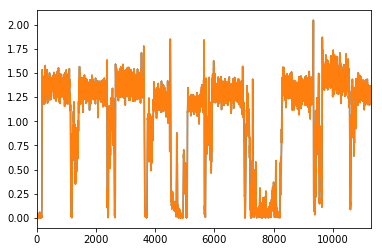

In [40]:
df.spd.plot()
plt.show()

7 peaks 

In [3]:
df=df.sort_values(['utc']) #sort by timestamp

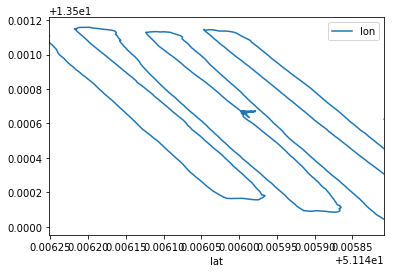

In [213]:
import matplotlib.pyplot as plt
import numpy as np

df.plot.line(x='lat', y='lon')

#plt.axhline(med)
plt.show()

# How to detect wine rows?

METHOD: 

* Take lon values (y), remove impact of outliers (z.B. mal nach vorne gegangen, auf Schuhe gefilmt etc.) by differencing $$ diff_t = -1 * \sum_{t-10}^{t}  lon_t \quad \forall t$$ --> wie bei Time Series (ARIMA)-> stationarity by differencing
* remove all rows where $diff_t \gt 10^{-6} $  --> neuer Datensatz $Data^* \in Data$
* Create horizontal lines for percentils, count intersections by $counter_i = sign(data_t - percentil_i)_t - sign(data_t - percentil_i)_{t-1}$  mit $i \in Percentiles$
* Kann man sich wie eine Richtung vorstellen, nehme deinen Datensatz und ziehe das Perzentil_i davon ab. Wenn sich die Richtung ändert, muss mein Datensatz das Perzentil überschritten haben (hier kommt auch das Differenzieren ins Spiel--> Wege die mal vor und zurückgegangen sind, sollen nicht berücksichtigt werden, Moving Average wahrscheinlich das gleiche Ergebnis)
* Anzahl der Weinreihen = $Modus({cnt_i})$ --> Ich ziehe aus allen Perzentilen den Reihenwert heraus, der am häufigsten in den Perzentilen vorkommt --> Auch weil viel Varianz in den Daten drin ist

In [235]:
from scipy import stats

def no_wine(df):
    df['diff'] = df.lon.diff(periods=50)

    df_ = df[df['diff'] > 10**-6] # remove outliers

    med = np.percentile(df.lon,50)
    fiftif = np.percentile(df.lon,55)
    fortifor = np.percentile(df.lon,45)
    se = np.percentile(df.lon,60)
    quart = np.percentile(df.lon,40)
    idx = len(np.argwhere(np.diff(np.sign(df_.lon - med)) != 0).reshape(-1) )
    idx_2 = len(np.argwhere(np.diff(np.sign(df_.lon - se)) != 0).reshape(-1))
    idx_3 = len(np.argwhere(np.diff(np.sign(df_.lon - quart)) != 0).reshape(-1))
    idx_4 = len(np.argwhere(np.diff(np.sign(df_.lon - fiftif)) != 0).reshape(-1))
    idx_5 = len(np.argwhere(np.diff(np.sign(df_.lon - fortifor)) != 0).reshape(-1))

    no_wine = stats.mode(np.array((idx,idx_2,idx_3,idx_4,idx_5)))[0][0] # multiple percentils for accuracy
    return no_wine
no_wine

Other possible Methods
* Speed radically declines when row is finished
* Direction changes
* What about outliers? --> machine stops suddently or changes direction for any reason

# get angle/direction

The direction between $P(lat_i,lon_i) $ and $P(lat_j, lon_j) $ is defined by the vector $a_{ij}$

$$ dir_{ij} = Vector(lat_i - lat_j, lon_i - lon_j ) $$
$$ \theta = atan2(sin(Δlong)*cos(lat2), cos(lat1)*sin(lat2) − sin(lat1)*cos(lat2)*cos(Δlong)) $$


In [116]:
import math

def angle_between(p1, p2):
    # tuple p1,p2
    pointA = np.radians(p1)
    pointB = np.radians(p2)
    lat1 = math.radians(pointA[0])
    lat2 = math.radians(pointB[0])


    diffLong = math.radians(pointB[1] - pointA[1])

    x = math.sin(diffLong) * math.cos(lat2)
    y = math.cos(lat1) * math.sin(lat2) - (math.sin(lat1)
            * math.cos(lat2) * math.cos(diffLong))

    initial_bearing = math.atan2(x, y)

    # Now we have the initial bearing but math.atan2 return values
    # from -180° to + 180° which is not what we want for a compass bearing
    # The solution is to normalize the initial bearing as shown below
    initial_bearing = math.degrees(initial_bearing)
    compass_bearing = (initial_bearing + 360) % 360
    return compass_bearing


In [148]:
def np_angle(p1, p2):
    # vectorizeed version
    # p1,p2 = numpy array lon,lat
    # math to rads is linear transformation, therefore difference is the same
    
    #pointA = np.radians(p1)
    #pointB = np.radians(p2)
    p1 = np.radians(p1)
    p2 = np.radians(p2)
    lat1 = p2.shift(1)
    lat2 = p2[:]
    
    diffLong = p1.shift(1)-p1
    diffLot = p2.shift(1)-p2


    x = np.sin(diffLong) * np.cos(lat2)
    y = np.cos(lat1) * np.sin(lat2) - (np.sin(lat1)
            * np.cos(lat2) * np.cos(diffLong))

    initial_bearing = np.arctan2(x, y)
    
    # Now we have the initial bearing but math.atan2 return values
    # from -180° to + 180° which is not what we want for a compass bearing
    # The solution is to normalize the initial bearing as shown below
    initial_bearing = np.degrees(initial_bearing)
    compass_bearing = (initial_bearing + 360) % 360
    return compass_bearing



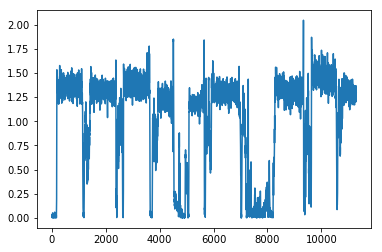

In [158]:
plt.plot(np.diff(df.spd,0))
plt.show()

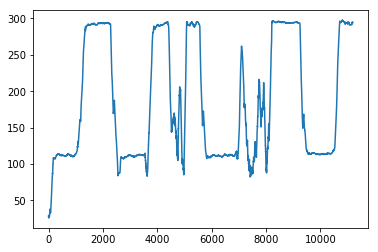

In [174]:
def running_mean(x, N):
    return np.convolve(x, np.ones((N,))/N, mode='valid')

plt.plot(running_mean(np_angle(df.lon,df.lat),100))
plt.show()

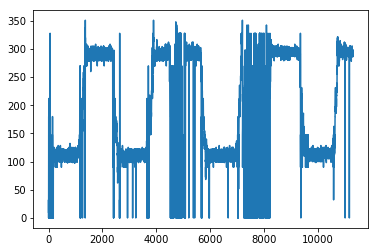

In [164]:
plt.plot(np_angle(df.lon,df.lat))
plt.show()

In [117]:
p1 = (51.146253,13.501110)
p2 = (51.146253,10.501109)
angle_between(p1,p2) #clockwise -->  (0:N,90:E,180:S,270:W)

270.00040786814657

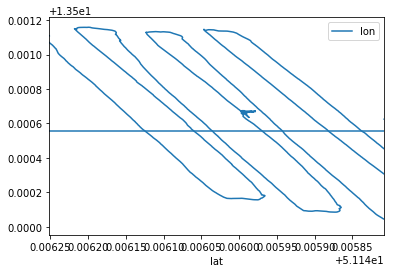

In [73]:
df['diff'] = df.lon.diff(periods=1)

df_ = df[df['diff'] > 10**-6]
df.plot.line(x='lat', y='lon')
plt.axhline(med)
#df_.iloc[np.argwhere(np.diff(np.sign(df_.lon - med)) != 0).reshape(-1) + 0].plot(x='lat',y='lon')
plt.show()

# For all GoPros TODO

# Background filtering in videos

http://opencv-python-tutroals.readthedocs.io/en/latest/py_tutorials/py_video/py_bg_subtraction/py_bg_subtraction.html#background-subtraction

An improved adaptive background mixture model for real-time tracking with shadow detection (KadewTraKuPong)

Efficient Adaptive Density Estimation per Image Pixel for the Task of Background Subtraction

In [ ]:
import numpy as np
import cv2

cap = cv2.VideoCapture('GOPR0189.MP4')

fgbg = cv2.createBackgroundSubtractorMOG2(detectShadows = False)

while(1):
    ret, frame = cap.read()

    fgmask = fgbg.apply(frame)

    cv2.imshow('frame',fgmask)
    k = cv2.waitKey(30) & 0xff
    if k == 27:
        break

cap.release()
cv2.destroyAllWindows()


klappt nicht so richtig, auch nicht bei Parameterveränderung

In [ ]:
#!/usr/bin/python

########################################################################
#
# Function and script for converting videos to images.
#
# This can be run as a script in a Linux shell by typing:
#
#    python convert.py
#
# Or by running:
#
#    chmod +x convert.py
#    ./convert.py
#
# Requires the program avconv to be installed.
# Tested with avconv v. 9.18-6 on Linux Mint.
#
# Implemented in Python 3.5 (seems to work in Python 2.7 as well)
#
########################################################################
#
# This file is part of the TensorFlow Tutorials available at:
#
# https://github.com/Hvass-Labs/TensorFlow-Tutorials
#
# Published under the MIT License. See the file LICENSE for details.
#
# Copyright 2016 by Magnus Erik Hvass Pedersen
#
########################################################################

import os
import subprocess
import argparse

########################################################################


def video2images(in_dir, out_dir, crop_size, out_size, framerate, video_exts):
    """
    Convert videos to images. The videos are located in the directory in_dir
    and all its sub-directories which are processed recursively. The directory
    structure is replicated to out_dir where the jpeg-images are saved.
    :param in_dir:
        Input directory for the videos e.g. "/home/magnus/video/"
        All sub-directories are processed recursively.
    :param out_dir:
        Output directory for the images e.g. "/home/magnus/video-images/"
    :param crop_size:
        Integer. First the videos are cropped to this width and height.
    :param out_size:
        Integer. After cropping, the videos are resized to this width and height.
    :param framerate:
        Integer. Number of frames to grab per second.
    :param video_exts:
        Tuple of strings. Extensions for video-files e.g. ('.mts', '.mp4')
        Not case-sensitive.
    :return:
        Nothing.
    """

    # Convert all video extensions to lower-case.
    video_exts = tuple(ext.lower() for ext in video_exts)

    # Number of videos processed.
    video_count = 0

    # Process all the sub-dirs recursively.
    for current_dir, dir_names, file_names in os.walk(in_dir):
        # The current dir relative to the input directory.
        relative_path = os.path.relpath(current_dir, in_dir)

        # Name of the new directory for the output images.
        new_dir = os.path.join(out_dir, relative_path)

        # If the output-directory does not exist, then create it.
        if not os.path.exists(new_dir):
            os.makedirs(new_dir)

        # For all the files in the current directory.
        for file_name in file_names:
            # If the file has a valid video-extension. Compare lower-cases.
            if file_name.lower().endswith(video_exts):
                # File-path for the input video.
                in_file = os.path.join(current_dir, file_name)

                # Split the file-path in root and extension.
                file_root, file_ext = os.path.splitext(file_name)

                # Create the template file-name for the output images.
                new_file_name = file_root + "-%4d.jpg"

                # Complete file-path for the output images incl. all sub-dirs.
                new_file_path = os.path.join(new_dir, new_file_name)

                # Clean up the path by removing e.g. "/./"
                new_file_path = os.path.normpath(new_file_path)

                # Print status.
                print("Converting video to images:")
                print("- Input video:   {0}".format(in_file))
                print("- Output images: {0}".format(new_file_path))

                # Command to be run in the shell for the video-conversion tool.
                cmd = "avconv -i {0} -r {1} -vf crop={2}:{2} -vf scale={3}:{3} -qscale 2 {4}"

                # Fill in the arguments for the command-line.
                cmd = cmd.format(in_file, framerate, crop_size, out_size, new_file_path)

                # Run the command-line in a shell.
                subprocess.call(cmd, shell=True)

                # Increase the number of videos processed.
                video_count += 1

                # Print newline.
                print()

    print("Number of videos converted: {0}".format(video_count))


########################################################################
# This script allows you to run the video-conversion from the command-line.

if __name__ == "__main__":
    # Argument description.
    desc = "Convert videos to images. " \
           "Recursively processes all sub-dirs of INDIR " \
           "and replicates the dir-structure to OUTDIR. " \
           "The video is first cropped to CROP:CROP pixels, " \
           "then resized to SIZE:SIZE pixels and written as a jpeg-file. "

    # Create the argument parser.
    parser = argparse.ArgumentParser(description=desc)

    # Add arguments to the parser.
    parser.add_argument("--indir", required=True,
                        help="input directory where videos are located")

    parser.add_argument("--outdir", required=True,
                        help="output directory where images will be saved")

    parser.add_argument("--crop", required=True, type=int,
                        help="the input videos are first cropped to CROP:CROP pixels")

    parser.add_argument("--size", required=True, type=int,
                        help="the input videos are then resized to SIZE:SIZE pixels")

    parser.add_argument("--rate", required=False, type=int, default=5,
                        help="the number of frames to convert per second")

    parser.add_argument("--exts", required=False, nargs="+",
                        help="list of extensions for video-files e.g. .mts .mp4")

    # Parse the command-line arguments.
    args = parser.parse_args()

    # Get the arguments.
    in_dir = args.indir
    out_dir = args.outdir
    crop_size = args.crop
    out_size = args.size
    framerate = args.rate
    video_exts = args.exts

    if video_exts is None:
        # Default extensions for video-files.
        video_exts = (".MTS", ".mp4")
    else:
        # A list of strings is provided as a command-line argument, but we
        # need a tuple instead of a list, so convert it to a tuple.
        video_exts = tuple(video_exts)

    # Print the arguments.
    print("Convert videos to images.")
    print("- Input dir: " + in_dir)
    print("- Output dir: " + out_dir)
    print("- Crop width and height: {0}".format(crop_size))
    print("- Resize width and height: {0}".format(out_size))
    print("- Frame-rate: {0}".format(framerate))
    print("- Video extensions: {0}".format(video_exts))
    print()

    # Perform the conversions.
    video2images(in_dir=in_dir, out_dir=out_dir,
                 crop_size=crop_size, out_size=out_size,
                 framerate=framerate, video_exts=video_exts)

########################################################################